# Multi-Scenario MORDM


Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [1]:
# 1) import model and functionalities
from ema_workbench import Model, RealParameter, ScalarOutcome, SequentialEvaluator, MultiprocessingEvaluator, ema_logging, Policy

In [2]:
from scipy.optimize import brentq
import math

In [3]:
import numpy as np

#THE FUNCTION FOR ANTHROPOGENIC POLLUTION FOR CLOSED LOOP CONTROL
def a_t(X, #x is a scalar, pollution at time t
        c=[],
        r=[],
        w=[],
        n=2):

    a = sum([w[j]*(abs((X-c[j])/r[j]))**3 for j in range(n)])
    return min(max(a, 0.01), 0.1)

In [4]:
import numpy as np
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant)
from dps_lake_model import lake_model
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)



ema_logging.log_to_stderr(ema_logging.INFO)
lake_model = Model('lakeproblem', function=lake_model)
lake_model.time_horizon = 100 

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

#set levers
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2),
                     RealParameter("r2", 0, 2),
                     RealParameter("w1", 0, 1)]

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE, expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MINIMIZE, expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,1))]



In [5]:
#convergence metrics
convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

In [6]:
import os

from ema_workbench import (perform_experiments, ema_logging, save_results, 
                           load_results, Policy)
from ema_workbench.em_framework import samplers
from ema_workbench.em_framework import sample_levers

# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

# perform experiments
nr_experiments = 500

policies = sample_levers(lake_model,n_samples=5)
results = perform_experiments(lake_model, nr_experiments, policies=policies)


[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


#### From Quakkels website
Step 2.2: Select policy relevant scenarios based on the exploration results:
   - max_P >= median(~ 5)
   - reliability <= median (~0.5)
   - inertia <= median (~1)
   - utility <= median (~0.15)

#### Create four scenarios?
# Step 2.2: Select policy relevant scenarios based on the exploration results:
This was done in the paper by Kwakkel et al by tresholds for values calculated out of the outcomes, and then from these 4 maximally diverse scenarios are chosen to make sure that there is a big enoug representation of the data set.


In [7]:
experiments, outcomes = results
oois = sorted(outcomes.keys())

In [8]:
print(outcomes)

{'max_P': array([3.50585707, 3.09909243, 2.3747899 , ..., 2.58832002, 4.55332265,
       4.62573596]), 'utility': array([2.25699291, 1.98289422, 1.01023612, ..., 0.90039569, 1.22299192,
       2.34665346]), 'inertia': array([0.99, 0.99, 0.99, ..., 0.99, 0.99, 0.99]), 'reliability': array([0.08  , 0.122 , 0.1183, ..., 0.05  , 0.0715, 0.0874])}


In [9]:
#here, the policy-relevant scenarios defined by median thresholds are selected
indices = []
for ooi in oois:
    if ooi in ['max_P', 'inertia']:
        a = outcomes[ooi] > np.median(outcomes[ooi])     
    else: 
        a = outcomes[ooi] < np.median(outcomes[ooi])
    indices.append(a)
indices = np.swapaxes(indices, 0, 1)
logical_index = np.array([index.all() for index in indices])
newExperiments = experiments[logical_index]
newOutcomes = {}
for ooi in oois:
    newOutcomes[ooi] = outcomes[ooi][logical_index]
newResults = newExperiments, newOutcomes

In [10]:
print(len(newOutcomes['max_P']))

0


In [11]:
new_fn = '206_experiments_openloop_Apollution.tar.gz'
save_results(newResults, new_fn)

[MainProcess/INFO] results saved successfully to C:\Users\joren\OneDrive\Documenten\Universiteit\Delft\Q4-2020\Model-based-Decision-making\Assignments\FabiosDecisions\epa1361\Week-5-6-robustness-and-direct-search\206_experiments_openloop_Apollution.tar.gz


Now these results can be analyzed with the scenario-selection file.

Results: maximum diversity and solutions: 1.0307457510054456, [[array([ 21,  28,  33, 104])]]

In [12]:
#Find the Maximally diverse: 
import pandas as pd
import copy
#0 : non policy-relevant scenarios
#1 : policy-relevant scenarios
#2 : prim results
#3 : diverse SELECTED
#4 : random selected

sel_column = logical_index.astype(int)
selected = [ 21,  28,  33, 104]
random_selected = [81, 289, 391, 257]
count = 0
for index, i in enumerate(sel_column):
    
    if logical_index[index]: #this is computed at the bottom of  the notebook
        sel_column[index] = 2
    if i:
        if count in selected:
            sel_column[index] = 3
        count +=1 #the reason for the count is that the selected indices correspond to the dataset of 206 scenarios 
            
    if index in random_selected:
        sel_column[index] = 4
        
print(len(sel_column))

2500


In [13]:
set(sel_column)


{0, 4}

C:\Users\joren\anaconda3\envs\MBDM\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


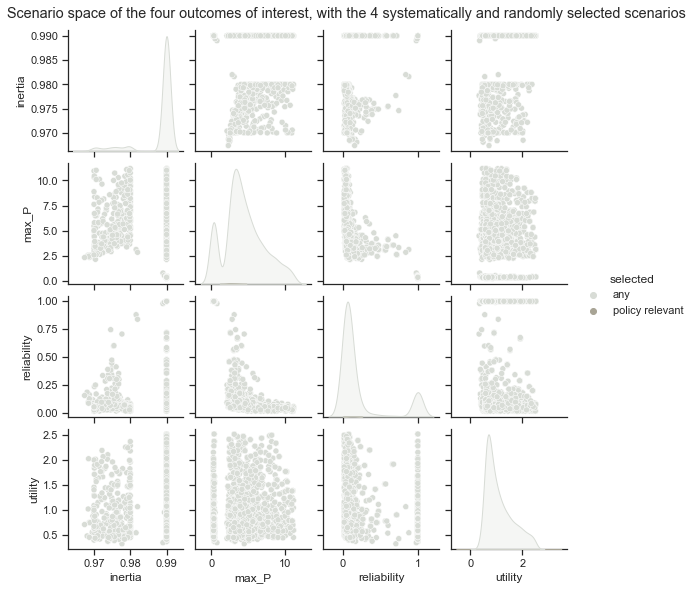

In [14]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

data = copy.copy(outcomes)
data['selected'] = sel_column
data = pd.DataFrame(data)

sns.set(style="ticks", color_codes=True)    
sns.axes_style('white')
colors = ["light grey", "greyish"]

for entry, name in zip(np.unique(sel_column), ['any', 'policy relevant','prim', 'diversity_selected', 'random_selected']):
    data.replace(entry, name, inplace=True)

g = sns.pairplot(data, hue='selected', height=2, markers = ['o', 'o'],
             palette=sns.xkcd_palette(colors), vars=oois)

plt.suptitle("Scenario space of the four outcomes of interest, with the 4 systematically and randomly selected scenarios", y=1.02)

tag_indices = {0: 'inertia', 1: 'max_P', 2: 'reliability', 3: 'utility'}   

g.savefig('./scatter_diverse_random_prim.png', dpi=600)
plt.show()


## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


#### Prepare the scenarios for usage

In [15]:
np.partition(outcomes["utility"],4)[:4]

array([0.33056972, 0.37332115, 0.35261803, 0.37716302])

In [16]:
list_utility = outcomes["utility"].tolist()

In [17]:
list_chosen = sorted(range(len(list_utility)), key=lambda k: list_utility[k])[:4]  
sorted(range(len(list_utility)), key=lambda k: list_utility[k])[:4]

[1664, 1779, 1651, 1710]

In [18]:
#list_chosen = [169, 162, 170, 140]
selected_scenarios = experiments.iloc[list_chosen,:].copy()
scenarios_dictlist = selected_scenarios.to_dict("records")
selected_scenarios


,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
1664,0.244919,0.932772,0.043488,4.279013,0.002708,1.007914,0.968893,1.504385,1.81116,0.660809,164,3,lakeproblem
1779,0.269686,0.937632,0.048967,4.117198,0.004042,1.007914,0.968893,1.504385,1.81116,0.660809,279,3,lakeproblem
1651,0.292067,0.936860,0.043223,3.723400,0.004287,1.007914,0.968893,1.504385,1.81116,0.660809,151,3,lakeproblem
1710,0.416567,0.930986,0.045341,2.759896,0.003042,1.007914,0.968893,1.504385,1.81116,0.660809,210,3,lakeproblem


In [19]:
selected_scenarios.drop(columns = ['c1','model', 'c2', 'r1', 'r2', 'w1', 'scenario', 'policy'], inplace = True)


In [20]:
selected_scenarios
scenarios_dictlist = selected_scenarios.to_dict("records")


#### Use the found scenarios

In [21]:
from ema_workbench import Scenario
scenario_1 = Scenario("1", **scenarios_dictlist[0])
scenario_2 = Scenario("2", **scenarios_dictlist[1])
scenario_3 = Scenario("3", **scenarios_dictlist[2])
scenario_4 = Scenario("4", **scenarios_dictlist[3])

In [22]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint

constraints = [Constraint("max pollution", outcome_names="max_P",
                          function=lambda x:max(0, x-1))]

In [23]:
print(constraints)

[Constraint('max pollution', variable_name=['max_P'], function=<function <lambda> at 0x000001578B5311F0>)]


In [24]:
#convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[1,1.01,1.01,1.01]),
#                      EpsilonProgress()]
convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]
print(convergence_metrics)

[<ema_workbench.em_framework.optimization.HyperVolume object at 0x0000015784EAF1F0>, <ema_workbench.em_framework.optimization.EpsilonProgress object at 0x000001578B3FE190>]


In [25]:
print(scenario_1)

Scenario({'b': 0.24491911693291124, 'delta': 0.9327718248852865, 'mean': 0.04348798298957894, 'q': 4.279012588254728, 'stdev': 0.002707619145348398})


In [26]:
from ema_workbench import MultiprocessingEvaluator
from ema_workbench import ema_logging

with MultiprocessingEvaluator(lake_model) as evaluator:
    results_c, convergence = evaluator.optimize(nfe=2000, searchover='levers',
                                    epsilons=[0.1, 0.1], reference = scenario_1, convergence=convergence_metrics, constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/2000 nfe
[MainProcess/INFO] generation 5: 498/2000 nfe
[MainProcess/INFO] generation 10: 990/2000 nfe
[MainProcess/INFO] generation 15: 1488/2000 nfe
[MainProcess/INFO] generation 20: 1984/2000 nfe
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool


In [27]:
solutions_list = []
solutions_list.append(results_c)

In [28]:
print(results_c)

         c1        c2        r1        r2        w1     max_P   utility  \
0  0.642995  0.598047  0.616651  0.837276  0.216103  0.373764  0.303660   
1  0.286926  0.328587  0.093972  1.952456  0.924509  0.283161  0.202538   
2  0.450204  0.493471  0.118661  1.901428  0.809097  0.415675  0.324100   
3  0.367709  0.510076  0.097515  1.945755  0.748452  0.343655  0.279199   

   inertia  reliability  
0   0.9900          1.0  
1   0.9312          1.0  
2   0.6219          1.0  
3   0.6584          1.0  


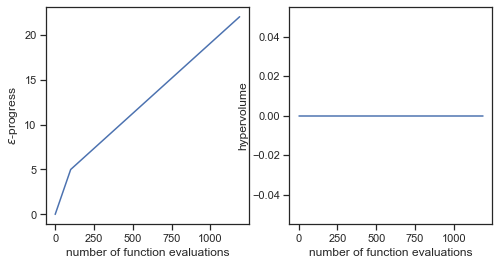

In [29]:

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [30]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_c, convergence = evaluator.optimize(nfe=2000, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.01, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints, reference = scenario_2)
solutions_list.append(results_c)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/2000 nfe
[MainProcess/INFO] generation 5: 497/2000 nfe
[MainProcess/INFO] generation 10: 995/2000 nfe
[MainProcess/INFO] generation 15: 1491/2000 nfe
[MainProcess/INFO] generation 20: 1990/2000 nfe
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool


In [31]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_c, convergence = evaluator.optimize(nfe=2000, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.01, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints, reference = scenario_3)
solutions_list.append(results_c)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/2000 nfe
[MainProcess/INFO] generation 5: 495/2000 nfe
[MainProcess/INFO] generation 10: 995/2000 nfe
[MainProcess/INFO] generation 15: 1485/2000 nfe
[MainProcess/INFO] generation 20: 1980/2000 nfe
[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool


In [32]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_c, convergence = evaluator.optimize(nfe=2000, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.01, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints, reference = scenario_4)
solutions_list.append(results_c)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/2000 nfe
[MainProcess/INFO] generation 5: 493/2000 nfe
[MainProcess/INFO] generation 10: 990/2000 nfe
[MainProcess/INFO] generation 15: 1482/2000 nfe
[MainProcess/INFO] generation 20: 1971/2000 nfe
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool


In [33]:
solutions_list

[         c1        c2        r1        r2        w1     max_P   utility  \
 0  0.642995  0.598047  0.616651  0.837276  0.216103  0.373764  0.303660   
 1  0.286926  0.328587  0.093972  1.952456  0.924509  0.283161  0.202538   
 2  0.450204  0.493471  0.118661  1.901428  0.809097  0.415675  0.324100   
 3  0.367709  0.510076  0.097515  1.945755  0.748452  0.343655  0.279199   
 
    inertia  reliability  
 0   0.9900          1.0  
 1   0.9312          1.0  
 2   0.6219          1.0  
 3   0.6584          1.0  ,
          c1        c2        r1        r2        w1     max_P   utility  \
 0  0.147146  0.327306  1.158080  0.207849  0.203841  0.271170  0.215077   
 1  0.383797  0.371209  0.097583  0.382897  0.689827  0.368558  0.312378   
 2  0.523884  0.448312  0.734184  0.103302  0.041346  0.428043  0.350073   
 
    inertia  reliability  
 0   0.9899          1.0  
 1   0.6473          1.0  
 2   0.6387          1.0  ,
          c1        c2        r1        r2        w1     max_P   ut

In [34]:
import pandas as pd
all_solutions = pd.concat([solutions_list[0], solutions_list[1], solutions_list[2], solutions_list[3]])
all_solutions = all_solutions.reset_index(drop = True)

In [35]:
chosen_solutions = []
chosen_solutions.append(all_solutions.max_P.idxmax())
chosen_solutions.append(all_solutions.max_P.idxmin())
chosen_solutions.append(all_solutions.utility.idxmax())
chosen_solutions.append(all_solutions.utility.idxmin())
chosen_solutions.append(all_solutions.inertia.idxmax())
chosen_solutions.append(all_solutions.inertia.idxmin())
chosen_solutions.append(all_solutions.reliability.idxmax())
chosen_solutions.append(all_solutions.reliability.idxmin())

In [36]:
solutions = all_solutions.iloc[chosen_solutions,:].drop_duplicates()

In [37]:
def max_regret(data):
    maximum = data.max()
    regret = []
    for value in data:
        temp = maximum - value
        regret.append(temp)
    return max(regret)

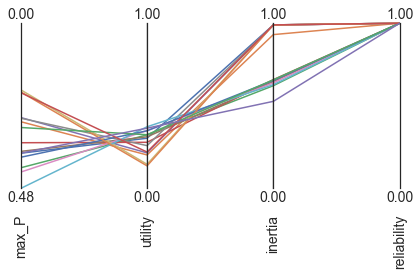

In [38]:
from ema_workbench.analysis import parcoords

data = all_solutions.loc[:, [o.name for o in lake_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0
limits.loc[1, ['utility', 'inertia', 'reliability']] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')
plt.show()

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [39]:
all_solutions

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.642995,0.598047,0.616651,0.837276,0.216103,0.373764,0.303660,0.9900,1.0000
1,0.286926,0.328587,0.093972,1.952456,0.924509,0.283161,0.202538,0.9312,1.0000
2,0.450204,0.493471,0.118661,1.901428,0.809097,0.415675,0.324100,0.6219,1.0000
3,0.367709,0.510076,0.097515,1.945755,0.748452,0.343655,0.279199,0.6584,1.0000
4,0.147146,0.327306,1.158080,0.207849,0.203841,0.271170,0.215077,0.9899,1.0000
5,0.383797,0.371209,0.097583,0.382897,0.689827,0.368558,0.312378,0.6473,1.0000
6,0.523884,0.448312,0.734184,0.103302,0.041346,0.428043,0.350073,0.6387,1.0000
7,0.237621,0.347463,1.501507,0.232424,0.399661,0.273070,0.259016,0.9895,1.0000
8,0.252560,0.428682,0.307420,1.733661,0.955764,0.191487,0.146084,0.9900,1.0000
9,0.503336,0.359273,0.138767,1.953208,0.963632,0.475002,0.373118,0.6278,1.0000


In [40]:
all_solutions.dtypes

c1             float64
c2             float64
r1             float64
r2             float64
w1             float64
max_P          float64
utility        float64
inertia        float64
reliability    float64
dtype: object

In [41]:
new_results = all_solutions[all_solutions['reliability'] > 0.9]

In [42]:
# define policy designs of interest in a dict {key=lever, value=value}
inputs = ["c1", "c2", "r1", "r2", "w1"]
policies = []

for nr, entry in new_results.iterrows():
    policy_dict = {}
    
    for i in inputs:
        policy_dict[i] = entry[i]
    
    policies.append(Policy(policy_dict))

In [43]:
# evaluate these policies under 1000 scenarios

scenarios = 100 
with MultiprocessingEvaluator(lake_model) as evaluator:
    newest_experiments, newest_outcomes = evaluator.perform_experiments(scenarios=scenarios, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 15 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [44]:
# signal to ratio = mean / std

newest_outcomes_df = pd.DataFrame(newest_outcomes)
# Get the policy from each result
newest_outcomes_df['policy'] = newest_experiments['policy']
# Make the policy into a format I can group
newest_outcomes_df['policy'] = newest_outcomes_df['policy'].apply(lambda x: tuple(x.items()))
    # Change policy value to something more readable
temp_dict = {}
for i in range(len(newest_outcomes_df['policy'].unique())):
    temp_dict[newest_outcomes_df['policy'].unique()[i]] = i+1
newest_outcomes_df['policy'] = newest_outcomes_df['policy'].apply(lambda x: temp_dict[x])
newest_outcomes_df

,max_P,utility,inertia,reliability,policy
0,0.144501,0.356369,0.9900,1.0000,1
1,0.137100,0.173647,0.9900,1.0000,1
2,0.161170,0.199132,0.9900,1.0000,1
3,0.120459,0.256765,0.9900,1.0000,1
4,0.138786,0.248765,0.9900,1.0000,1
...,...,...,...,...,...
1495,0.283178,0.141000,0.9900,1.0000,15
1496,2.192811,0.154357,0.9735,0.6268,15
1497,0.130417,0.213463,0.9900,1.0000,15
1498,9.406579,0.413973,0.9756,0.0300,15


In [45]:
# Make calculations

mean_df = newest_outcomes_df.groupby(by='policy').mean()
std_df = newest_outcomes_df.groupby(by='policy').std()

signal_ratio_df = pd.DataFrame(columns = ['max_P', 'reliability', 'inertia', 'utility'])

signal_ratio_df['max_P'] = mean_df['max_P'] / std_df['max_P']
signal_ratio_df['utility'] = mean_df['utility'] / std_df['utility']
signal_ratio_df['inertia'] = mean_df['inertia'] / std_df['inertia']
signal_ratio_df['reliability'] = mean_df['reliability'] / std_df['reliability']
signal_ratio_df

,max_P,reliability,inertia,utility
policy,,,,
1,0.662082,1.960835,124.163637,0.975198
2,0.662209,1.959020,124.826909,0.976034
3,0.663433,1.959883,124.628404,0.975835
4,0.664136,1.958958,123.329232,0.975979
5,0.662767,1.960932,123.635430,0.975440
6,0.662592,1.961014,125.223785,0.975390
7,0.662525,1.960135,124.054855,0.976331
8,0.663076,1.959714,125.110351,0.975758
9,0.663138,1.959494,125.038215,0.975743


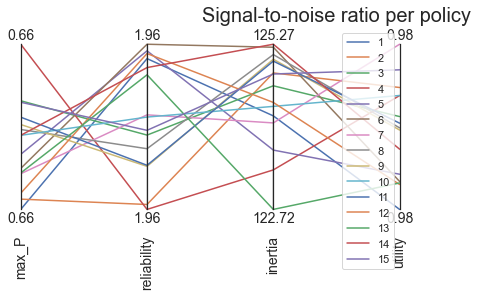

In [46]:
limits = parcoords.get_limits(signal_ratio_df)
axes = parcoords.ParallelAxes(limits)
axes.plot(signal_ratio_df)

plt.legend(signal_ratio_df.index.values)
plt.title('Signal-to-noise ratio per policy', fontsize=20)
plt.show()

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [47]:
# Get the most desirable values for each result
best_results = {'max_P': 0, 'reliability': 1, 'inertia': 1, 'utility': newest_outcomes_df['utility'].max()}
# Is there a better way to get the maximum utility?????

# Calculate regret
regret_df = pd.DataFrame(columns = ['max_P', 'reliability', 'inertia', 'utility','policy'])
regret_df['max_P'] = newest_outcomes_df['max_P'] - best_results['max_P']
regret_df['reliability'] = best_results['reliability'] - newest_outcomes_df['reliability']
regret_df['inertia'] = best_results['inertia'] - newest_outcomes_df['inertia']
regret_df['utility'] = best_results['utility'] - newest_outcomes_df['utility']
regret_df['policy'] = newest_outcomes_df['policy']
regret_df = regret_df.groupby(by='policy').max()

regret_df

,max_P,reliability,inertia,utility
policy,,,,
1,10.891621,0.97,0.0294,1.950353
2,10.891693,0.97,0.0297,1.950243
3,10.891768,0.97,0.0297,1.950270
4,10.891096,0.97,0.0294,1.950320
5,10.891532,0.97,0.0296,1.950244
6,10.891783,0.97,0.0292,1.950246
7,10.891824,0.97,0.0292,1.950316
8,10.891595,0.97,0.0296,1.950279
9,10.891562,0.97,0.0294,1.950287


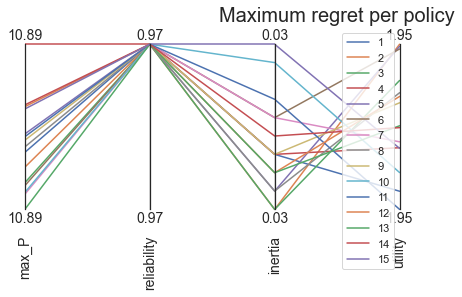

In [48]:
limits = parcoords.get_limits(regret_df)
axes = parcoords.ParallelAxes(limits)
axes.plot(regret_df)

# invert axes so it is more intuitive to read, higher regret is down, so higher desirability is up
axes.invert_axis(['max_P', 'reliability', 'inertia', 'utility']) 
plt.legend(regret_df.index.values)
plt.title('Maximum regret per policy', fontsize=20)
plt.show()